In [1]:
#Import necessary packages
import itertools as it
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #Helps draw arrows on edges 

In [14]:
start_time = time.time()

table =     [[[2],[0],[3]],
         [[3],[0],[1]],
         [[1],[4],[2,5]],
         [[0],[5],[3]],
         [[0],[3],[4]]]


#Convert table to zero-based numbering
for i in range(len(table)):
    for j in range(len(table[i])):
        for k in range(len(table[i][j])):
            table[i][j][k] -= 1         

In [15]:
#Create necessary lists and dictionaries
mapping = {}
reverseMapping = {}

boards = [[]]

#Get moves from the table by iterating through values in the table
for i in range(len(table)):
    for j in range(len(table[i])):
        for k in range(len(table[i][j])):
            value = table[i][j][k]
        
            startPoint = (i,j,k)
            
            #Consider value if it represents an edge
            if value != -1:
                
                #Find the pair of the initial value
                for u in range(len(table[value])):
                    for v in range(len(table[value][u])):
                        if table[value][u][v] == i:
                            endPoint = (value, u, v)

                #Check if the endPoint already has its own mapping
                if endPoint not in mapping.keys():
                    mapping[startPoint] = endPoint
                    reverseMapping[endPoint] = startPoint
                    boards.append([])

In [16]:
#Get sinks/sources from the table
illegal = []
cycles = []

emptyBoard = []
for i in range(len(mapping)):
    emptyBoard.append(0)

for i in range(len(table)):
    source = emptyBoard.copy()
    sink = emptyBoard.copy()
    
    #Set all moves to be the same direction with respect to the row vertex
    for j in range(len(table[i])):
        for k in range(len(table[i][j])):
            if table[i][j][k] > -1:
                
                #Set value as positive or negative based on the orientation of the edge in "mapping"
                if (i,j,k) in mapping.keys():
                    source[list(mapping.keys()).index((i,j,k))] = 1
                    sink[list(mapping.keys()).index((i,j,k))] = -1
                else:
                    source[list(reverseMapping.keys()).index((i,j,k))] = -1
                    sink[list(reverseMapping.keys()).index((i,j,k))] = 1
                    
    #Add to list of sinks and sources
    illegal.append(source)
    illegal.append(sink)

#Get cycles from the table
for j in range(len(table[0])-1):
    clockwise = emptyBoard.copy()
    counterClockwise = emptyBoard.copy()
    
    #Set all moves to be the same direction with respect to the cell
    for i in range(len(table)):
        for k in range(len(table[i][j])):
            if table[i][j][k] > -1:
                
                #Set value as positive or negative based on the orientation of the edge in "mapping"
                if (i,j,k) in mapping.keys():
                    clockwise[list(mapping.keys()).index((i,j,k))] = 1
                    counterClockwise[list(mapping.keys()).index((i,j,k))] = -1
                else:
                    clockwise[list(reverseMapping.keys()).index((i,j,k))] = -1
                    counterClockwise[list(reverseMapping.keys()).index((i,j,k))] = 1
                    
    #Add to list of cycles
    cycles.append(clockwise)
    cycles.append(counterClockwise)

In [17]:
#Consider all possible boards 
print("Total combinations to consider: ", len(list(it.product([0,1,-1], repeat = len(mapping)))))
print()
print("Combinations: Time (seconds)")

digraph = nx.DiGraph()

num = 1
for combination in it.product([0,1,-1],repeat = len(mapping)):
    
    #Program running update
    if num % 100000 == 0:
        print(num, ": {:.3f}".format(time.time() - start_time), sep = "")
    
    #Check for sinks/sources by checking if board is equal to all nonzero entries of a sink/source
    legal = True
    for sink in illegal:
        equivalent = True
        for i in range(len(combination)):
            if (sink[i] != 0) and (sink[i] != combination[i]):
                equivalent = False
        if equivalent == True:
            legal = False
            
    #Check for cycles by checking if board is equal to all nonzero entries of a cycle
    unfinished = True
    for cycle in cycles:
        equivalent = True
        for i in range(len(combination)):
            if (cycle[i] != 0) and (cycle[i] != combination[i]):
                equivalent = False
        if equivalent == True:
            unfinished = False
    
    #Add legal combinations to boards and digraph
    if legal:
        marked = 0
        
        #Add to proper part of boards list given number of moves played in the board
        for move in combination:
            if move != 0:
                marked += 1
        
        boards[marked].append(combination)
        
        #Label as an end state if a cycle exists
        if unfinished:
            digraph.add_node(combination, position = [-1,-1,-1], layer = marked)
        else:
            digraph.add_node(combination, position = [0,1,1], layer = marked)
    num += 1

print("End Time: ", " {:.3f} seconds".format(time.time() - start_time))
print()

Total combinations to consider:  729

Combinations: Time (seconds)
End Time:   2.467 seconds



In [18]:
#Calculate how many legal boards there are
print("Total legal boards:", len(digraph.nodes))
print()

#Add edges to digraph by checking every node
print("Boards: Time (seconds)")

num = 0
for i in range(len(mapping)):
    for board in boards[i]:
        
        #Program running update
        num += 1
        if num % 100000 == 0:
            print(num, ": {:.3f}".format(time.time() - start_time), sep = "")
        
        #Only add edges to boards without cycles
        if digraph.nodes[board]["position"] == [-1,-1,-1]:

            #For every zero in the list, add a 1 or -1 and add an edge to that node if it exists
            for j in range(len(board)):
                if board[j] == 0:
                    positive = list(board)
                    negative = list(board)
                    positive[j] = 1
                    negative[j] = -1
                    if tuple(positive) in digraph.nodes:
                        digraph.add_edge(board,tuple(positive))
                    if tuple(negative) in digraph.nodes:
                        digraph.add_edge(board,tuple(negative))
                        
print("Time: ", " {:.3f} seconds".format(time.time() - start_time))

Total legal boards: 287

Boards: Time (seconds)
Time:   2.967 seconds


In [19]:
#Label the nodes in the digraph as n and p positions starting at the end of the game
print("Total legal boards:", len(digraph.nodes))
print()
print("Boards: Time (seconds)")

num = 0
for i in range(len(boards)):
    for board in boards[len(boards) - i - 1]:
        
        #Program running update
        num += 1
        if num % 100000 == 0:
            print(num, ": {:.3f}".format(time.time() - start_time), sep = "")
        
        #Remove nodes with an in-degree of zero because they cannot be reached without the game already ending
        if digraph.in_degree(board) == 0 and i != len(boards) - 1:
            turns = 0
            for entry in board:
                if entry != 0:
                    turns += 1
                    
            digraph.remove_node(board)
        
        #[0,1,1]-position if an end state
        elif len(digraph.edges(board)) == 0:
            digraph.nodes[board]["position"] = [0,1,1]
            
        else:
            #x1 labeling
            x1count = 0
            for edge in digraph.edges(board):
                if digraph.nodes[edge[1]]["position"][0] == 1:
                    digraph.nodes[board]["position"][1] = 1
                    x1count+=1
            if x1count == 0:
                digraph.nodes[board]["position"][1] = 0
                
            
            #x0 Labeling
            x0count = 0
            for edge in digraph.edges(board):
                if digraph.nodes[edge[1]]["position"][2] == 0:
                    digraph.nodes[board]["position"][0] = 0
                elif digraph.nodes[edge[1]]["position"][2] == 1:
                    x0count+=1
            if x0count == len(digraph.edges(board)):
                digraph.nodes[board]["position"][0] = 1

            #x2 Labeling
            x2count = 0
            for edge in digraph.edges(board):
                if digraph.nodes[edge[1]]["position"][1] == 0:
                    digraph.nodes[board]["position"][2] = 0
                elif digraph.nodes[edge[1]]["position"][1] == 1:
                    x2count+=1
            if x2count == len(digraph.edges(board)):
                digraph.nodes[board]["position"][2] = 1


print("Time: ", " {:.3f} seconds".format(time.time() - start_time))

Total legal boards: 287

Boards: Time (seconds)
Time:   3.477 seconds


In [20]:
#Determine which player has a winning strategy
print(digraph.nodes[tuple(emptyBoard)]["position"])

if digraph.nodes[tuple(emptyBoard)]["position"][0] == 1:
    print("Player 3 has a winning strategy")
if digraph.nodes[tuple(emptyBoard)]["position"][1] == 1:
    print("Player 1 has a winning strategy")
if digraph.nodes[tuple(emptyBoard)]["position"][2] == 1:
    print("Player 2 has a winning strategy")
if digraph.nodes[tuple(emptyBoard)]["position"] == [0,0,0]:
    print("No winning strategy")

[1, 1, 0]
Player 3 has a winning strategy
Player 1 has a winning strategy


In [21]:
len(boards)

7

In [22]:
len(digraph)

283

In [23]:
print("Nodes and their labels")
for node, data in digraph.nodes(data=True): 
    if 1 in data.values() and data["position"][0]==0:
        print(f"Node: {node}, Labels: {data}")

Nodes and their labels


In [24]:
print(mapping), print(len(mapping))

num=0
for key in mapping.keys():
    start_point=table[key[0]][key[1]][key[2]]+1
    end_point=table[mapping[key][0]][mapping[key][1]][mapping[key][2]]+1
    print("node to edge labels, index:", num+1, "edge start, edge end:", start_point, end_point)
    num+=1

{(0, 0, 0): (1, 2, 0), (0, 2, 0): (2, 0, 0), (1, 0, 0): (2, 2, 0), (2, 1, 0): (3, 2, 0), (2, 2, 1): (4, 1, 0), (3, 1, 0): (4, 2, 0)}
6
node to edge labels, index: 1 edge start, edge end: 2 1
node to edge labels, index: 2 edge start, edge end: 3 1
node to edge labels, index: 3 edge start, edge end: 3 2
node to edge labels, index: 4 edge start, edge end: 4 3
node to edge labels, index: 5 edge start, edge end: 5 3
node to edge labels, index: 6 edge start, edge end: 5 4


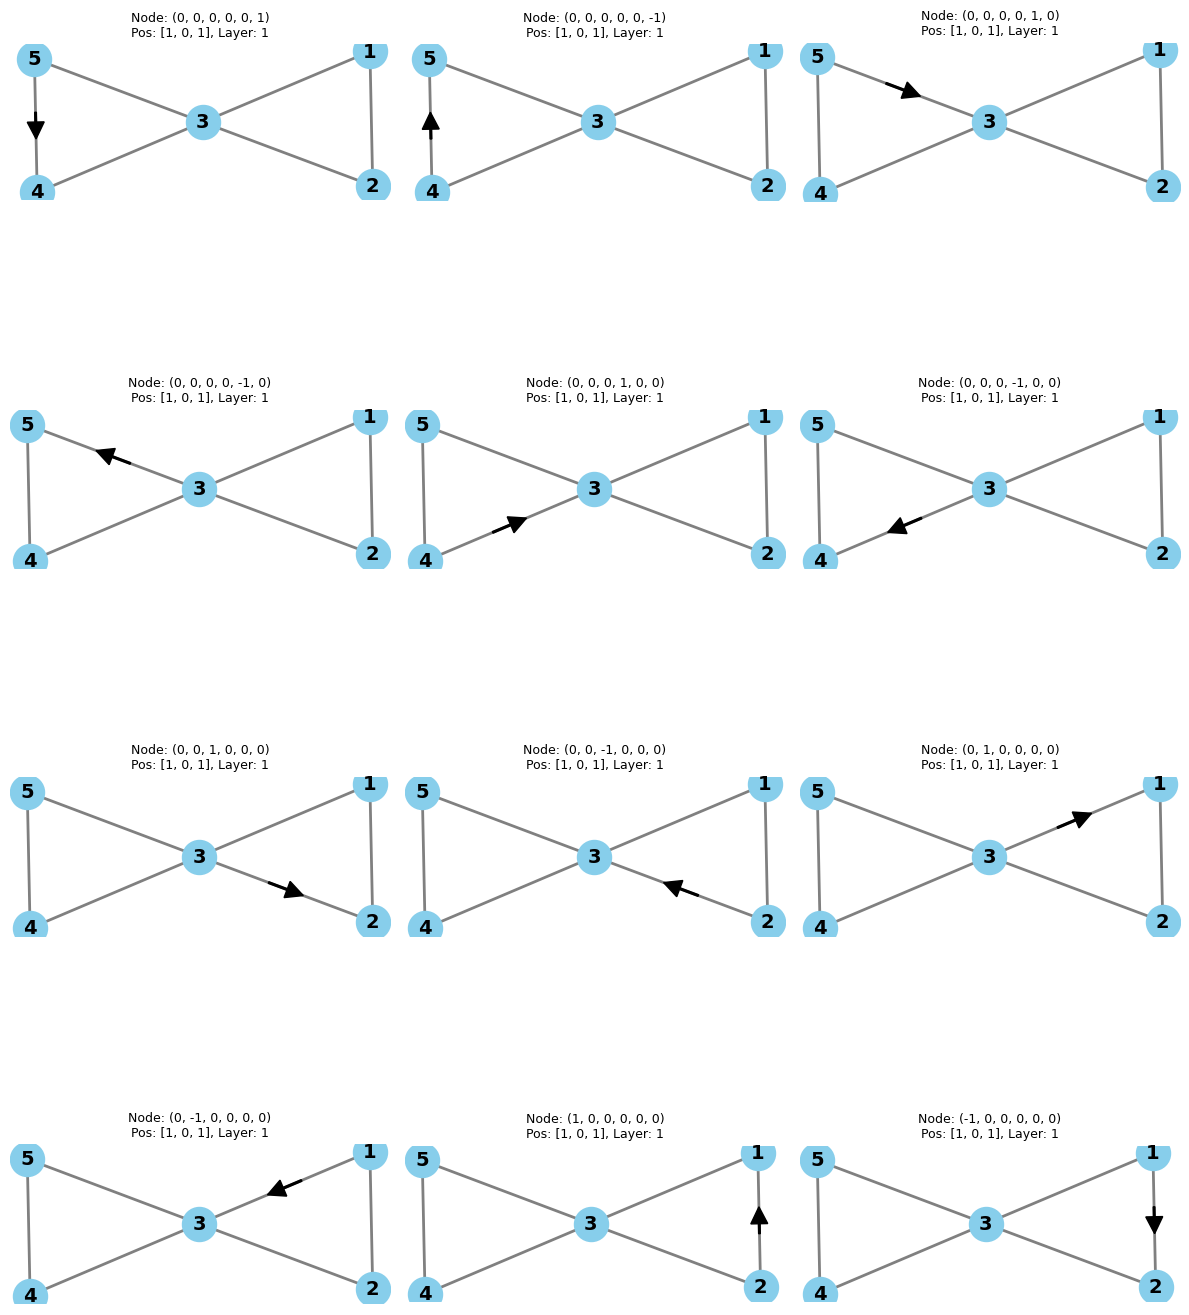

In [25]:
newtable = [[[2],[0],[3]],
         [[3],[0],[1]],
         [[1],[4],[2,5]],
         [[0],[5],[3]],
         [[0],[3],[4]]]

# Convert the table into a list of edges in correct order
def edges_from_table(table):
    edges = [] #will hold the edges in order
    seen = set() #keeps track of edges already added or "seen"
    for i in range(len(table)):  # goes through every single row of the matrix (each row represents a node)
        for j in range(len(table[i])): #goes through every single entry in each row
            for k in range(len(table[i][j])): #goes through every slot to find the values of neighboring nodes (important especially for cactus graphs when there might be more than one connecting node)
                v = table[i][j][k] #gets the value of the neighboring node
                if v != 0:   # skips empty cells
                    a, b = i + 1, v      # convert to 1-based index
                    edge = tuple(sorted((a, b))) #each edge is stored smallest number first
                    if edge not in seen: 
                        seen.add(edge) #if edge is new add it to the seen set
                        edges.append(edge) #saves the unique edge in order. builds the final edge list.
    return edges

#Collect all possible game board states (nodes as tuples with their attributes)
states = [(node, data) for node, data in digraph.nodes(data=True) if 1 in data.values()]
          # if 1 in data.values()]

def draw_board_with_state(table, state, ax=None):
    edges = edges_from_table(table)

    #Build graph for layout
    G = nx.Graph()
    G.add_nodes_from(range(1, len(table)+1))
    G.add_edges_from(edges)

    #Creates automatic layout for the graph's node position using a 'spring layout'. Spring layout models edges like springs and nodes like repelling charges, so connected nodes stay closer and unconnected nodes spread out naturally.
    pos = nx.spring_layout(G, seed=42)  

    if ax is None:
        fig, ax = plt.subplots()

    #Draw vertices
    for v, (x, y) in pos.items():
        ax.scatter(x, y, s=600, c="skyblue", zorder=2)  #draw node as a circle
        ax.text(x, y, str(v), ha="center", va="center", fontsize=14, weight="bold") # label the node

    #Draw edges + arrows
    for (u, v), label in zip(edges, state):
        x1, y1 = pos[u] #coordinates of first node
        x2, y2 = pos[v] #coordinates of second node

        #Draws edge
        ax.plot([x1, x2], [y1, y2], color="gray", lw=2, zorder=1)
 
        if label != 0:  #Only draw an arrow if this edge has a direction in the current state
            mx, my = (x1 + x2)/2, (y1 + y2)/2
            dx, dy = (x2 - x1), (y2 - y1)

            if label == 1:  #reverse arrow
                dx, dy = -dx, -dy

            dx, dy = dx*0.2, dy*0.2  #scale arrow

            arrow = mpatches.FancyArrow(
                mx - dx/2, my - dy/2, dx, dy,
                color="black",
                width=0.01,
                length_includes_head=True,
                head_width=0.1,
                head_length=0.1,
                zorder=3
            )
            ax.add_patch(arrow)

    ax.set_aspect("equal")
    ax.axis("off")

#Set up the plotting grid to display all game states
n = len(states)
cols = min(3, n)
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

if rows == 1 and cols == 1:
    axes = [[axes]]
elif rows == 1:
    axes = [axes]

flat_axes = [a for row in axes for a in row]

#Draw each game state on its own subplot
for ax, (node, data) in zip(flat_axes, states):
    draw_board_with_state(newtable, list(node), ax=ax)
    pos_label = data.get("position", [])
    layer_label = data.get("layer", [])
    ax.set_title(f"Node: {node}\nPos: {pos_label}, Layer: {layer_label}", fontsize=9)

#Hide any unused subplots (if number of states < grid size)
for ax in flat_axes[len(states):]:
    ax.axis("off")

#Adjust layout so titles and plots don't overlap
plt.tight_layout()
plt.show()
